Dimensiones de la imagen: (2048, 2048)


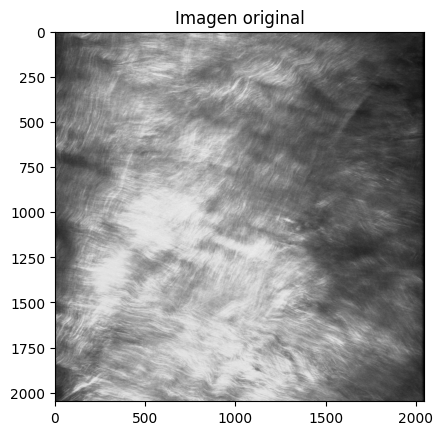

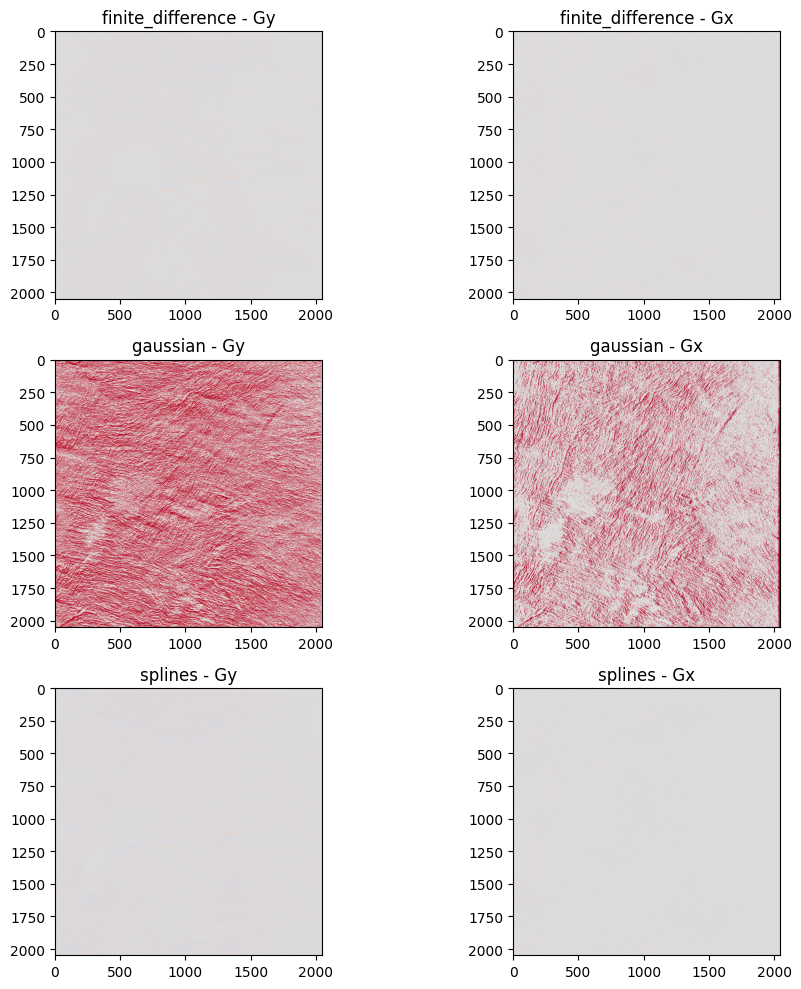

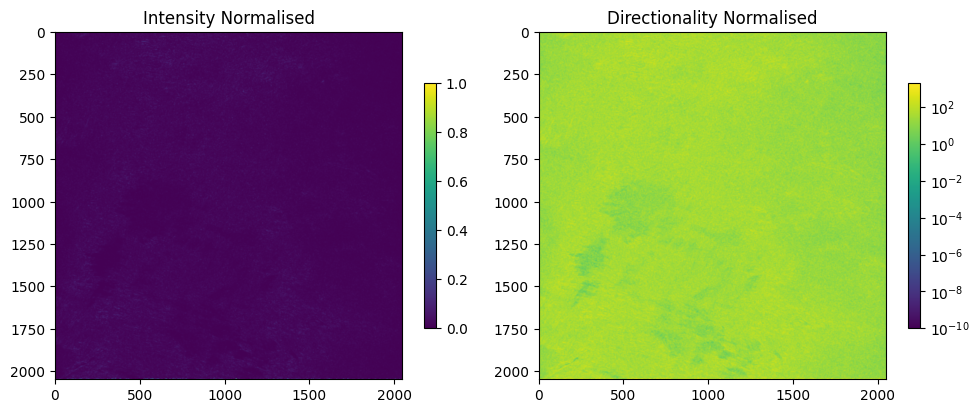

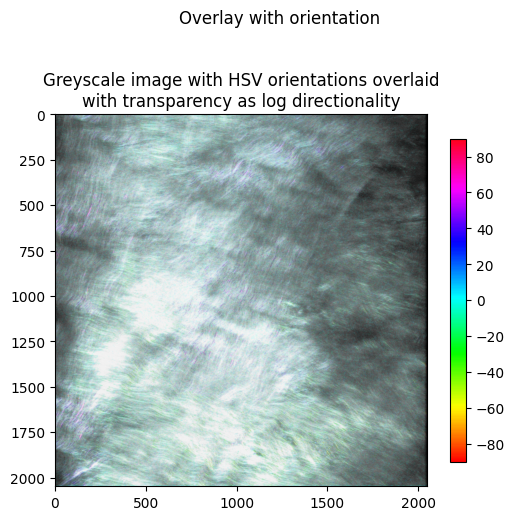

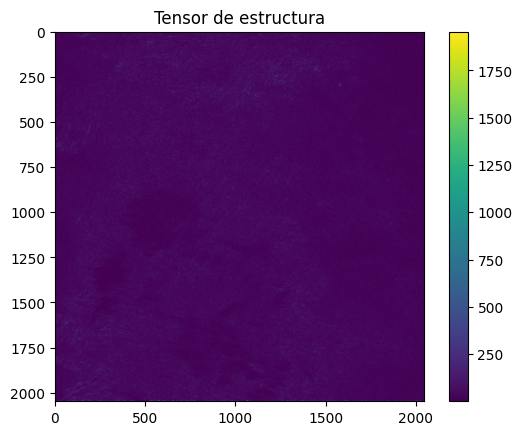

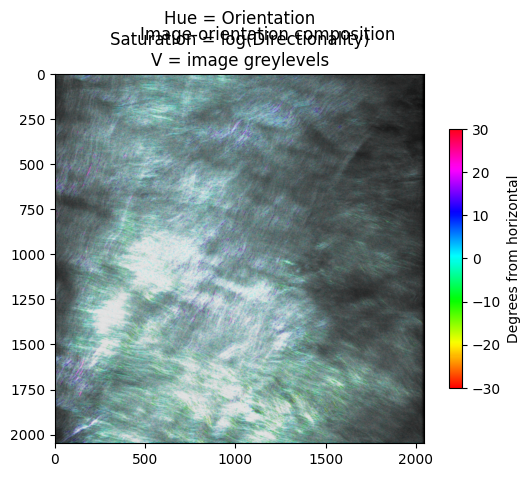

100%|██████████| 58/58 [00:00<00:00, 559.56it/s]


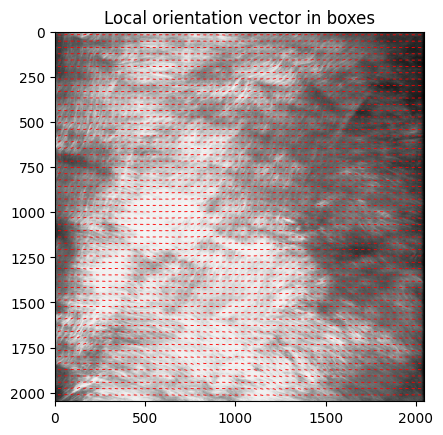

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import orientationpy
import matplotlib.colors

# Cargar la imagen en escala de grises
image_path = "C:\\Users\\danwo\\Desktop\\ZS0001_TI_25XW_Rhodopsin_Au\\IVM4110#_TI_25XW_Rhodopsin_Au.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {image_path}")

print(f"Dimensiones de la imagen: {image.shape}")

# Mostrar la imagen original
plt.imshow(image, cmap="gray")
plt.title("Imagen original")
plt.show()

# Calcular gradientes con diferentes métodos
methods = ["finite_difference", "gaussian", "splines"]
fig, axes = plt.subplots(len(methods), 2, figsize=(10, 10))

for i, mode in enumerate(methods):
    gradients = orientationpy.computeGradient(image, mode=mode)
    Gy, Gx = gradients[-2:]  # Extraer solo Gy y Gx
    
    # Mostrar gradientes
    axes[i, 0].imshow(Gy, cmap="coolwarm", vmin=-64, vmax=64)
    axes[i, 0].set_title(f"{mode} - Gy")
    
    axes[i, 1].imshow(Gx, cmap="coolwarm", vmin=-64, vmax=64)
    axes[i, 1].set_title(f"{mode} - Gx")

plt.tight_layout()
plt.show()

# Calcular el tensor de estructura
structureTensor = orientationpy.computeStructureTensor([Gy, Gx], sigma=2)

# Calcular la dirección y orientación
orientations = orientationpy.computeOrientation(structureTensor)
directionality = np.linalg.norm(structureTensor, axis=0)

# Asegurar valores positivos para normalización logarítmica
directionality = np.where(~np.isfinite(directionality) | (directionality <= 0), 1e-10, directionality)

plt.figure(figsize=(10, 4))

# Mostrar intensidad normalizada
plt.subplot(1, 2, 1)
plt.imshow(directionality / directionality.max(), vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.title("Intensity Normalised")

# Mostrar dirección con normalización logarítmica
plt.subplot(1, 2, 2)
plt.imshow(directionality, norm=matplotlib.colors.LogNorm(vmin=1e-10, vmax=directionality.max()))
plt.title("Directionality Normalised")
plt.colorbar(shrink=0.7)

plt.tight_layout()
plt.show()

# Normalizar dirección
vmin, vmax = 10, np.max(directionality)
directionality = np.clip(directionality, vmin, vmax)
directionality = np.log(directionality)
directionality -= directionality.min()
directionality /= directionality.max()
directionality[image == 0] = 0

# Visualizar imagen con orientación HSV superpuesta
plt.figure(figsize=(6, 6))
plt.suptitle("Overlay with orientation")
plt.title("Greyscale image with HSV orientations overlaid\nwith transparency as log directionality")
plt.imshow(image, cmap="Greys_r", vmin=0)
plt.imshow(
    orientations["theta"],
    cmap="hsv",
    alpha=directionality * 0.5,
    vmin=-90,
    vmax=90,
)
plt.colorbar(shrink=0.7)
plt.show()

# Visualizar el tensor de estructura
plt.imshow(structureTensor.sum(axis=0), cmap="viridis")
plt.title("Tensor de estructura")
plt.colorbar()
plt.show()

# Convertir imagen a HSV
imDisplayHSV = np.zeros((image.shape[0], image.shape[1], 3), dtype="f4")
imDisplayHSV[:, :, 0] = (orientations["theta"] + 90) / 180  # Hue
imDisplayHSV[:, :, 1] = directionality  # Saturation
imDisplayHSV[:, :, 2] = image / image.max()  # Value

fig, ax = plt.subplots()
fig.suptitle("Image-orientation composition")
ax.set_title("Hue = Orientation\nSaturation = log(Directionality)\nV = image greylevels")
ax.imshow(matplotlib.colors.hsv_to_rgb(imDisplayHSV))

cmap = matplotlib.cm.hsv
norm = matplotlib.colors.Normalize(vmin=-30, vmax=30)
fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    label="Degrees from horizontal",
    shrink=0.7,
)

plt.show()

# Cálculo de orientación en bloques
boxSizePixels = 35
structureTensorBoxes = orientationpy.computeStructureTensorBoxes(
    [Gy, Gx], [boxSizePixels, boxSizePixels]
)
intensityBoxes = orientationpy.computeIntensity(structureTensorBoxes)
orientationsBoxes = orientationpy.computeOrientation(structureTensorBoxes, mode="fiber")
intensityBoxes /= intensityBoxes.max()

# Calcular centros de bloques
boxCentresY = np.arange(orientationsBoxes["theta"].shape[0]) * boxSizePixels + boxSizePixels // 2
boxCentresX = np.arange(orientationsBoxes["theta"].shape[1]) * boxSizePixels + boxSizePixels // 2

# Calcular componentes del vector
boxVectorsYX = orientationpy.anglesToVectors(orientationsBoxes)
boxVectorsYX[:, intensityBoxes < 0.05] = 0.0

plt.title("Local orientation vector in boxes")
plt.imshow(image, cmap="Greys_r", vmin=0)

plt.quiver(
    boxCentresX,
    boxCentresY,
    boxVectorsYX[1],
    boxVectorsYX[0],
    angles="xy",
    scale_units="xy",
    color="r",
    headwidth=0,
    headlength=0,
    headaxislength=1,
)
plt.show()


Ahora voy a hacer el mismo análisis pero en 4 ventanas de píxeles cuadradas diferentes dentro de la imagen

Dimensiones de la imagen: (2048, 2048)


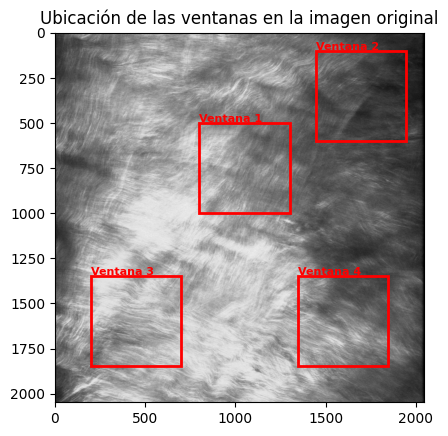

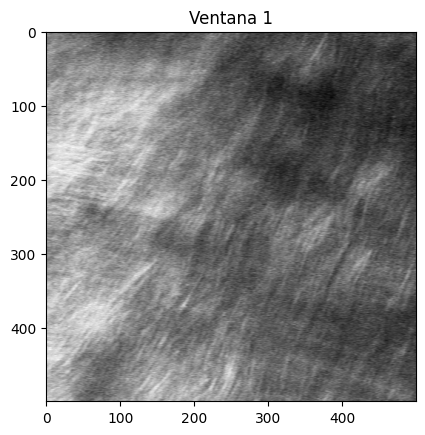

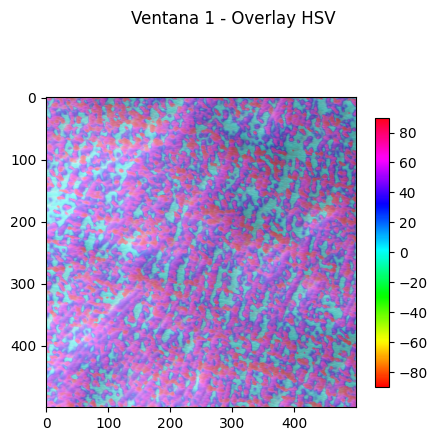

100%|██████████| 14/14 [00:00<00:00, 2326.75it/s]


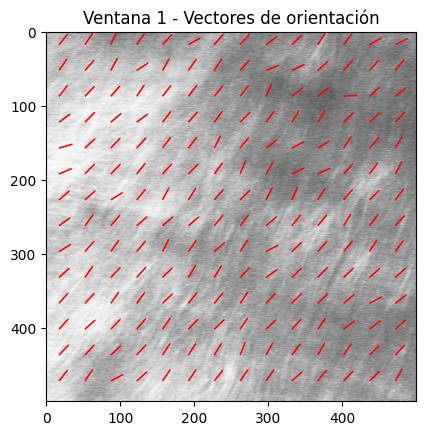

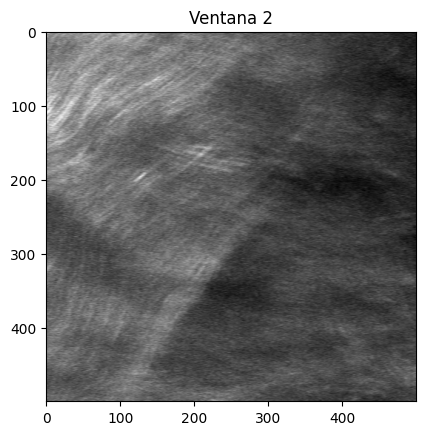

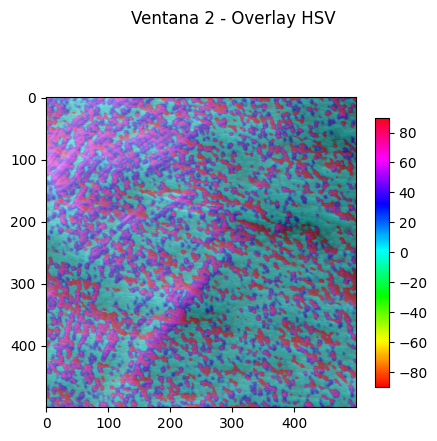

100%|██████████| 14/14 [00:00<00:00, 2333.60it/s]


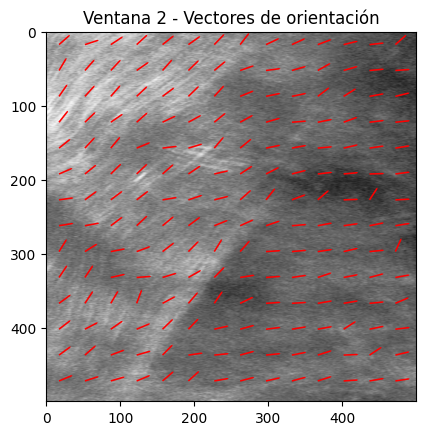

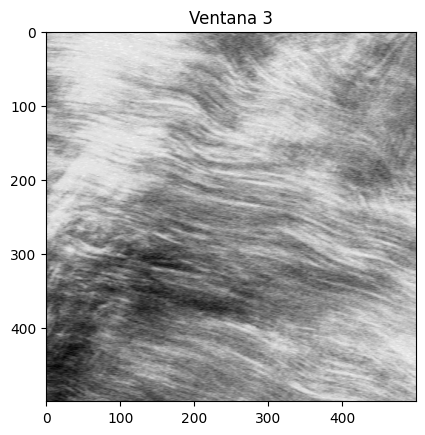

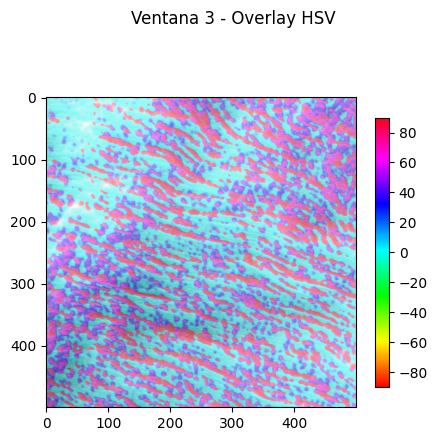

100%|██████████| 14/14 [00:00<00:00, 2333.87it/s]


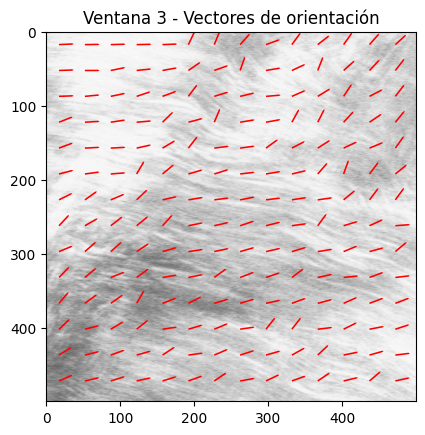

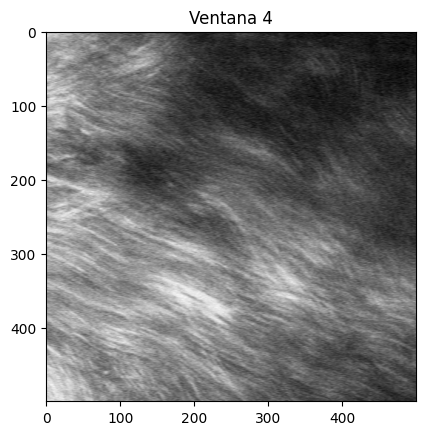

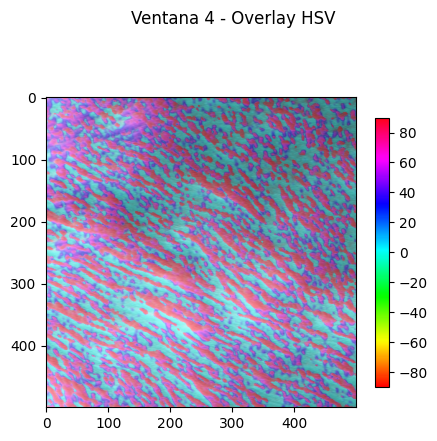

100%|██████████| 14/14 [00:00<00:00, 1915.96it/s]


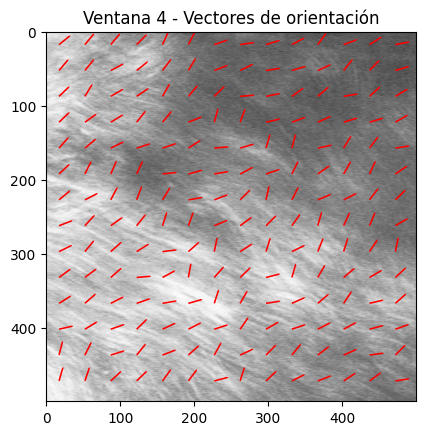

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import orientationpy
import matplotlib.colors
import matplotlib.patches as patches

# Cargar imagen en escala de grises
image_path = "C:\\Users\\danwo\\Desktop\\ZS0001_TI_25XW_Rhodopsin_Au\\IVM4110#_TI_25XW_Rhodopsin_Au.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {image_path}")

h, w = image.shape
print(f"Dimensiones de la imagen: {image.shape}")

# Definir el tamaño de la ventana
window_size = 500  # píxeles

# Coordenadas (Y, X) de las esquinas superiores izquierdas de las ventanas
window_coords = [
    (500, 800),
    (100, w - window_size - 100),
    (h - window_size - 200, 200),
    (h - window_size - 200, w - window_size - 200)
]

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")
ax.set_title("Ubicación de las ventanas en la imagen original")

for idx, (y, x) in enumerate(window_coords):
    rect = patches.Rectangle(
        (x, y), window_size, window_size,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x, y - 5, f"Ventana {idx+1}", color='red', fontsize=8, weight='bold')

plt.show()

for idx, (y, x) in enumerate(window_coords):
    sub_image = image[y:y+window_size, x:x+window_size]
    
    plt.figure()
    plt.imshow(sub_image, cmap="gray")
    plt.title(f"Ventana {idx+1}")
    plt.show()

    # Calcular gradientes
    gradients = orientationpy.computeGradient(sub_image, mode="gaussian")
    Gy, Gx = gradients[-2:]

    # Calcular tensor de estructura y orientación
    structureTensor = orientationpy.computeStructureTensor([Gy, Gx], sigma=2)
    orientations = orientationpy.computeOrientation(structureTensor)
    directionality = np.linalg.norm(structureTensor, axis=0)
    directionality = np.where(~np.isfinite(directionality) | (directionality <= 0), 1e-10, directionality)

    # Normalización
    vmin, vmax = 10, np.max(directionality)
    directionality = np.clip(directionality, vmin, vmax)
    directionality = np.log(directionality)
    directionality -= directionality.min()
    directionality /= directionality.max()
    directionality[sub_image == 0] = 0

    # Mostrar orientación HSV
    plt.figure(figsize=(5, 5))
    plt.suptitle(f"Ventana {idx+1} - Overlay HSV")
    plt.imshow(sub_image, cmap="Greys_r", vmin=0)
    plt.imshow(
        orientations["theta"],
        cmap="hsv",
        alpha=directionality * 0.5,
        vmin=-90,
        vmax=90,
    )
    plt.colorbar(shrink=0.7)
    plt.show()

    # Cálculo de orientación en bloques
    boxSizePixels = 35
    structureTensorBoxes = orientationpy.computeStructureTensorBoxes(
        [Gy, Gx], [boxSizePixels, boxSizePixels]
    )
    intensityBoxes = orientationpy.computeIntensity(structureTensorBoxes)
    orientationsBoxes = orientationpy.computeOrientation(structureTensorBoxes, mode="fiber")
    intensityBoxes /= intensityBoxes.max()

    # Calcular centros de bloques
    boxCentresY = np.arange(orientationsBoxes["theta"].shape[0]) * boxSizePixels + boxSizePixels // 2
    boxCentresX = np.arange(orientationsBoxes["theta"].shape[1]) * boxSizePixels + boxSizePixels // 2

    # Vectores de orientación
    boxVectorsYX = orientationpy.anglesToVectors(orientationsBoxes)
    boxVectorsYX[:, intensityBoxes < 0.05] = 0.0

    # Mostrar vectores
    plt.title(f"Ventana {idx+1} - Vectores de orientación")
    plt.imshow(sub_image, cmap="Greys_r", vmin=0)
    plt.quiver(
        boxCentresX,
        boxCentresY,
        boxVectorsYX[1],
        boxVectorsYX[0],
        angles="xy",
        scale_units="xy",
        color="r",
        headwidth=0,
        headlength=0,
        headaxislength=1,
    )
    plt.show()
